# Introduction and conclusions

### So, our best result on the test (on the challenge website) is mAP = 0.531, Recall = 0.932

The main results obtained on the train are highlighted in bold headings along the notebook. If you collapse all the headings, it will be easier to navigate, and you will see the intermediate results metrics.

Our main task was to start with minimal basic tools, without complicating things. Therefore, we started with TF-IDF, then used ready-made dense embeddings, and only then tried to generate our own embeddings.

1. We independently determined the best TF-IDF configuration, which independently gave the quality Recall=0.8963, mAP=0.4734. We checked which components and their weights are important, and which vectorizer parameters give a good result. We also checked the result when cleaning the text, but it was unsatisfactory.
2. Then we began to find out which patent components are important in the ready-made embeddings that were provided to us. Based on the search results, we selected TA separately and the sum of TA and claims from the allMini model.
3. After that, we began to combine the results of TF-IDF (vector of pairwise distance of vectors) and Dense Embeddings (similar to distance). First TA, then the sum of TA and claims. The latter turned out to be better.
4. Our innovative idea was to use a classifier trained on golden citations. The idea is that the citation examples are NOT likely to be the top ones in our distance vectors, which is why the hit quality of the predictions is so low. How then? This will help to know the classifier that returns the probability that the document is truly cited. The ranking by these probabilities is our final prediction. We did not use the division into train and test! Because the share of positive (gold) citations was already very low (1.1%), to lose data for the test. We can say that the test was the test data on the platform. We also tried RRF, it increased Recall to the maximum, but it still shows worse mAP than reranking with classificator.
6. Then we tried to generate dense embeddings using the Doc2Vec model. It worked bast for the fulltext component, achieving a Recall@100 of 0.6939 and a mAP of 0.2037. Although we tried fine-tuning the model, we could not significantly improve the results. Then, we decided to explore another approach using a different version of sBERT (all-MiniLM-L12-v2) to see if it could further improve recall and mAP, since our previous sBERT embeddings had already shown promising results. We tested different components: description only, title+description, and fulltext. The best performance was achieved using the title+description combination, with Recall@100=0.814 and mAP=0.3241. To further improve mAP, we did a grid search which enhanced mAP to 0.3374. However, the improvement was not significant.


### Structure:
1. Upload Data
2. Data Analysis
3. TF-IDF
4. Re-Ranking of TD-IDF
5. Dense Embeddings From Class
6. TF-IDF & Embeddings from Class
7. Doc2Vec
8. sBert-L12 (all-MiniLM-L12-v2)

# Import

In [1]:
import os
import random
import itertools
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import xgboost as xgb
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sentence_transformers import SentenceTransformer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import task1_modules
from task1_modules import (
    load_json_data,
    analyze_content,
    create_weighted_corpus,
    create_tfidf_matrix,
    prepare_tfidf_data,
    get_tfidf_recommendations,
    grid_search_tfidf,
    mean_recall_at_k,
    mean_average_precision,
    evaluate_recommendations,
    prepare_training_data_tfidf,
    get_mapping_dict,
    clean_text,
    re_rank_candidates_tfidf,
    load_embeddings_and_ids,
    get_dense_recommendations,
    grid_search_embedd_comp,
    combine_embed,
    grid_search_embedd_combinations,
    fuse_results_simple,
    prepare_training_data_fused,
    re_rank_candidates_fused,
    align_embeddings,
    fuse_results_rrf,
    grid_search_rrf,
    get_true_and_predicted,
    create_corpus,
    top_k_ranks,
    mean_ranking,
    train_doc2vec_model,
    create_doc2vec_embeddings,
    create_combined_corpus,
    prepare_training_data_sbert_l12,
    evaluate_recommendations_sbert_l12,
    re_rank_candidates_sbert_l12
)

In [3]:
import importlib
importlib.reload(task1_modules)

<module 'task1_modules' from '/content/task1_modules.py'>

# 1. Upload Data

## Raw Texts

In [ ]:
json_citing_train = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("./datasets/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("./datasets/Citation_JSONs/Citation_Train.json")

In [ ]:
citing_dataset_df = pd.DataFrame(json_citing_train)
citing_dataset_df_test = pd.DataFrame(json_citing_test)
nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)

gold_mapping = get_mapping_dict(mapping_dataset_df)

# 2. Data Analysis

In [ ]:
citing_dataset_df.head(3)

,Application_Number,Application_Date,Application_Category,Content
0,3650293,2020-05-13,A1,{'title': 'DEVICE FOR CONTROLLING THE BRAKING ...
1,3694265,2020-08-12,A1,{'title': 'TIME DIVISION MULTIPLEXING OF SYNCH...
2,3623522,2020-03-18,A1,{'title': 'LAUNDRY MACHINE AND CONTROL METHOD ...


In [ ]:
nonciting_dataset_df.head(3)

,Application_Number,Application_Date,Application_Category,Content
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',..."
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u..."
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog..."


In [ ]:
citing_dataset_df.isna().sum()

Application_Number      0
Application_Date        0
Application_Category    0
Content                 0
dtype: int64

In [ ]:
nonciting_dataset_df.isna().sum()

Application_Number      0
Application_Date        0
Application_Category    0
Content                 0
dtype: int64

In [ ]:
citing_dataset_df['Application_Number'].nunique(), len(citing_dataset_df)

(6829, 6831)

In [ ]:
nonciting_dataset_df['Application_Number'].nunique(), len(nonciting_dataset_df)

(16807, 16837)

In [ ]:
citing_dataset_df['Application_Category'].value_counts()

Application_Category
A1    6829
A9       2
Name: count, dtype: int64

In [ ]:
citing_dataset_df_test['Application_Category'].value_counts()

Application_Category
A1    1000
Name: count, dtype: int64

In [ ]:
nonciting_dataset_df['Application_Category'].value_counts()

Application_Category
B1    7932
A1    7354
A2    1396
B2     112
B9      40
B3       3
Name: count, dtype: int64

In [ ]:
mapping_dataset_df.head(3)

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A


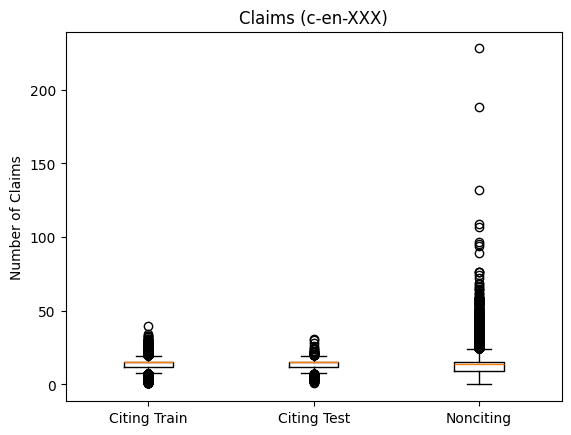

In [ ]:
citing_claims       = citing_dataset_df['Content'].apply(lambda c: analyze_content(c, flag='claims'))
citing_claims_test  = citing_dataset_df_test['Content'].apply(lambda c: analyze_content(c, flag='claims'))
nonciting_claims    = nonciting_dataset_df['Content'].apply(lambda c: analyze_content(c, flag='claims'))

plt.boxplot([citing_claims, citing_claims_test, nonciting_claims])
plt.xticks([1, 2, 3], ['Citing Train', 'Citing Test', 'Nonciting'])
plt.ylabel('Number of Claims')
plt.title('Claims (c-en-XXX)')
plt.show()

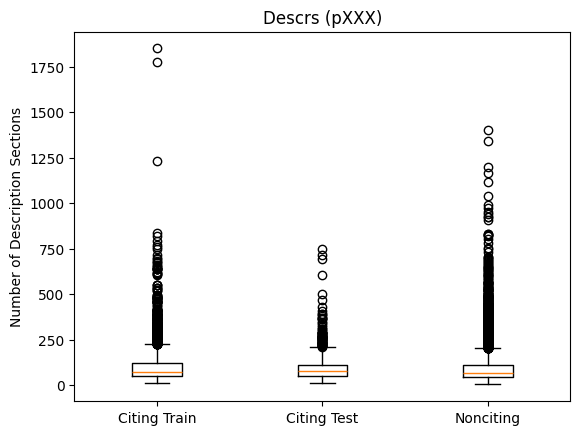

In [ ]:
citing_descr       = citing_dataset_df['Content'].apply(lambda c: analyze_content(c, flag='descr'))
citing_descr_test  = citing_dataset_df_test['Content'].apply(lambda c: analyze_content(c, flag='descr'))
nonciting_descr    = nonciting_dataset_df['Content'].apply(lambda c: analyze_content(c, flag='descr'))

plt.boxplot([citing_descr, citing_descr_test, nonciting_descr])
plt.xticks([1, 2, 3], ['Citing Train', 'Citing Test', 'Nonciting'])
plt.ylabel('Number of Description Sections')
plt.title('Descrs (pXXX)')
plt.show()

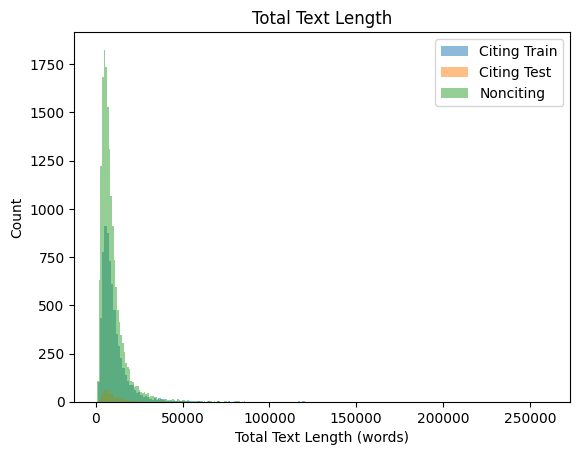

In [ ]:
citing_lengths       = citing_dataset_df['Content'].apply(lambda c: analyze_content(c, flag='total'))
citing_lengths_test  = citing_dataset_df_test['Content'].apply(lambda c: analyze_content(c, flag='total'))
nonciting_lengths    = nonciting_dataset_df['Content'].apply(lambda c: analyze_content(c, flag='total'))

plt.hist(citing_lengths,      alpha=0.5, bins=200, label='Citing Train')
plt.hist(citing_lengths_test, alpha=0.5, bins=200, label='Citing Test')
plt.hist(nonciting_lengths,   alpha=0.5, bins=200, label='Nonciting')
plt.xlabel('Total Text Length (words)')
plt.ylabel('Count')
plt.title('Total Text Length')
plt.legend()
plt.show()

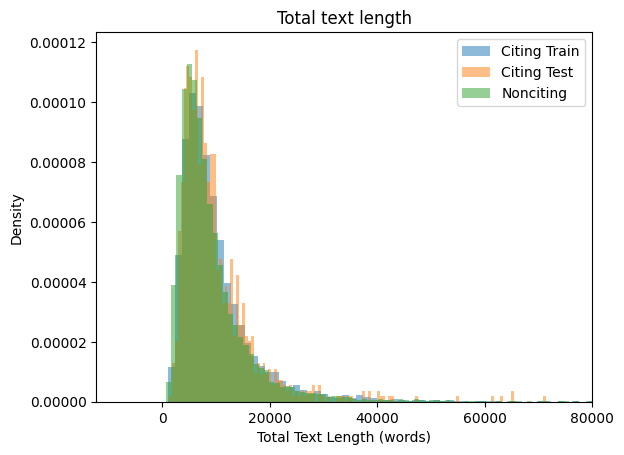

In [ ]:
plt.hist(citing_lengths, alpha=0.5, bins=200, label='Citing Train', density=True)
plt.hist(citing_lengths_test, alpha=0.5, bins=200, label='Citing Test', density=True)
plt.hist(nonciting_lengths, alpha=0.5, bins=200, label='Nonciting', density=True)
plt.xlabel('Total Text Length (words)')
plt.xlim(right=80000)
#plt.ylim(top=0.0)
plt.ylabel('Density')
plt.title('Total text length')
plt.legend()
plt.show()

# 3. TF-IDF

## 3.1 Grid Search by Weights of Patent Elements

The idea is that different components of patents can make different contributions to ranking. Therefore, we do a grid search by the contribution of different components. If the weight is greater than 1, then the text of this component is simply taken n times. To speed up grid searching, we start with 20% of the data, then refine the top parameters on the full dataset.

In [ ]:
#fraction 20%

weights_grid = {
    'title': [1, 2],
    'abstract': [0, 1],
    'claims': [0, 1, 2],
    'description': [0, 1, 2]
}

vectorizer_params = {'stop_words': ['english'],
                     'max_features': [10000]}

In [ ]:
best_params, best_score = grid_search_tfidf(
    citing_docs=json_citing_train,
    nonciting_docs=json_nonciting,
    gold_mapping=gold_mapping,
    weights_grid=weights_grid,
    vectorizer_params_grid=vectorizer_params,
    k=100,
    sample_fraction=0.2,
    random_state=42
)

TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 5340
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 0, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1195, mAP@100=0.0516, composite=0.0856


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 0, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0989, composite=0.1392


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 0, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0988, composite=0.1392


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1724, mAP@100=0.0776, composite=0.1250


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1790, mAP@100=0.0996, composite=0.1393


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0987, composite=0.1392


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 2, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1724, mAP@100=0.0758, composite=0.1241


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 2, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1791, mAP@100=0.0977, composite=0.1384


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 2, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1790, mAP@100=0.0997, composite=0.1393


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 0, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1631, mAP@100=0.0678, composite=0.1154


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 0, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0983, composite=0.1390


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 0, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0987, composite=0.1391


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 1, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1737, mAP@100=0.0786, composite=0.1262


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1790, mAP@100=0.0991, composite=0.1390


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 1, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0987, composite=0.1391


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 2, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1733, mAP@100=0.0785, composite=0.1259


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 2, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1791, mAP@100=0.0964, composite=0.1378


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 1, 'claims': 2, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1793, mAP@100=0.0998, composite=0.1396


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 5340
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 0, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1195, mAP@100=0.0516, composite=0.0856


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 0, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0988, composite=0.1392


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 0, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0989, composite=0.1392


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 1, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1746, mAP@100=0.0783, composite=0.1264


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1790, mAP@100=0.0997, composite=0.1393


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 1, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0986, composite=0.1391


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 2, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1724, mAP@100=0.0776, composite=0.1250


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 2, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1791, mAP@100=0.0981, composite=0.1386


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 0, 'claims': 2, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1790, mAP@100=0.0996, composite=0.1393


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 0, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1655, mAP@100=0.0717, composite=0.1186


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 0, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0980, composite=0.1388


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 0, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0987, composite=0.1391


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 1, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1744, mAP@100=0.0796, composite=0.1270


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1790, mAP@100=0.0992, composite=0.1391


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 1, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1796, mAP@100=0.0986, composite=0.1391


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 2, 'description': 0}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1733, mAP@100=0.0791, composite=0.1262


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 2, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1783, mAP@100=0.0969, composite=0.1376


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 2, 'abstract': 1, 'claims': 2, 'description': 2}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.1790, mAP@100=0.0999, composite=0.1394


In [ ]:
print("Best parameters:", best_params)
print("Best composite score:", best_score)

Best parameters: {'weights': {'title': 1, 'abstract': 1, 'claims': 2, 'description': 2}, 'vectorizer_params': {'stop_words': 'english', 'max_features': 10000}, 'recall': 0.17931918008784772, 'mAP': 0.09982739959808568, 'composite_score': 0.13957328984296669}
Best composite score: 0.13957328984296669


#### The values of claims and descriptions 1,1 are not much worse in quality then 2,2, but significantly faster in speed. Abstracts for 1,1 do not improve the quality. Therefore, the following weights were chosen for further work:

In [ ]:
##fraction 100%

weights = {
    'title': [1],
    'abstract': [0],
    'claims': [1],
    'description': [1]
}

vectorizer_params = {'stop_words': ['english'],
                     'max_features': [10000]}

In [ ]:
best_params, best_score = grid_search_tfidf(
    citing_docs=json_citing_train,
    nonciting_docs=json_nonciting,
    gold_mapping=gold_mapping,
    weights_grid=weights,
    vectorizer_params_grid=vectorizer_params,
    k=100,
    sample_fraction=1,
    random_state=42
)

TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000}, Recall@100=0.8449, mAP@100=0.3489, composite=0.5969


## Recall=0.8449, mAP=0.3489

## 3.2 Grid Search by Vectorizer Parameter

Now we want to check the contribution of different vectorizer parameters to the quality of prediction and ranking. Therefore, on 20% of the data we will do a grid search by hyperparameters of the function.

In [ ]:
# fraction 20%

weights = {
    'title': [1],
    'abstract': [0],
    'claims': [1],
    'description': [1]
}

vectorizer_params = {'stop_words': [None, 'english'],
                     'max_features': [10000, 30000],
                     'sublinear_tf': [False, True],
                     'strip_accents': ['ascii', None]}

In [ ]:
best_params, best_score = grid_search_tfidf(
    citing_docs=json_citing_train,
    nonciting_docs=json_nonciting,
    gold_mapping=gold_mapping,
    weights_grid=weights,
    vectorizer_params_grid=vectorizer_params,
    k=100,
    sample_fraction=0.2,
    random_state=42
)

TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': None, 'max_features': 10000, 'sublinear_tf': False, 'strip_accents': 'ascii'}, Recall@100=0.1571, mAP@100=0.0903, composite=0.1237


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': None, 'max_features': 10000, 'sublinear_tf': False, 'strip_accents': None}, Recall@100=0.1571, mAP@100=0.0902, composite=0.1237


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': None, 'max_features': 10000, 'sublinear_tf': True, 'strip_accents': 'ascii'}, Recall@100=0.1833, mAP@100=0.1204, composite=0.1518


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': None, 'max_features': 10000, 'sublinear_tf': True, 'strip_accents': None}, Recall@100=0.1833, mAP@100=0.1204, composite=0.1519


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': None, 'max_features': 30000, 'sublinear_tf': False, 'strip_accents': 'ascii'}, Recall@100=0.1549, mAP@100=0.0907, composite=0.1228


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': None, 'max_features': 30000, 'sublinear_tf': False, 'strip_accents': None}, Recall@100=0.1549, mAP@100=0.0906, composite=0.1228


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': None, 'max_features': 30000, 'sublinear_tf': True, 'strip_accents': 'ascii'}, Recall@100=0.1815, mAP@100=0.1226, composite=0.1521


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': None, 'max_features': 30000, 'sublinear_tf': True, 'strip_accents': None}, Recall@100=0.1815, mAP@100=0.1230, composite=0.1523


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000, 'sublinear_tf': False, 'strip_accents': 'ascii'}, Recall@100=0.1790, mAP@100=0.0996, composite=0.1393


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000, 'sublinear_tf': False, 'strip_accents': None}, Recall@100=0.1790, mAP@100=0.0996, composite=0.1393


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000, 'sublinear_tf': True, 'strip_accents': 'ascii'}, Recall@100=0.1829, mAP@100=0.1210, composite=0.1519


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 10000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 10000, 'sublinear_tf': True, 'strip_accents': None}, Recall@100=0.1836, mAP@100=0.1219, composite=0.1528


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 30000, 'sublinear_tf': False, 'strip_accents': 'ascii'}, Recall@100=0.1799, mAP@100=0.0995, composite=0.1397


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 30000, 'sublinear_tf': False, 'strip_accents': None}, Recall@100=0.1799, mAP@100=0.1000, composite=0.1400


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 30000, 'sublinear_tf': True, 'strip_accents': 'ascii'}, Recall@100=0.1819, mAP@100=0.1239, composite=0.1529


TF-IDF:   0%|          | 0/4733 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 30000, 'sublinear_tf': True, 'strip_accents': None}, Recall@100=0.1819, mAP@100=0.1242, composite=0.1530


In [ ]:
print("Best parameters:", best_params)
print("Best composite score:", best_score)

Best parameters: {'weights': {'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, 'vectorizer_params': {'stop_words': 'english', 'max_features': 30000, 'sublinear_tf': True, 'strip_accents': None}, 'recall': 0.1818814055636896, 'mAP': 0.12417208993011085, 'composite_score': 0.15302674774690023}
Best composite score: 0.15302674774690023


In [ ]:
##fraction 100%

weights = {
    'title': [1],
    'abstract': [0],
    'claims': [1],
    'description': [1]
}

vectorizer_params = {'stop_words': ['english'],
                     'max_features': [30000],
                     'sublinear_tf': [True]}

In [ ]:
best_params, best_score = grid_search_tfidf(
    citing_docs=json_citing_train,
    nonciting_docs=json_nonciting,
    gold_mapping=gold_mapping,
    weights_grid=weights,
    vectorizer_params_grid=vectorizer_params,
    k=100,
    sample_fraction=1,
    random_state=42
)

TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Vocabulary size: 30000
Grid params: weights={'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}, vect_params={'stop_words': 'english', 'max_features': 30000, 'sublinear_tf': True}, Recall@100=0.8963, mAP@100=0.4734, composite=0.6848


## Recall=0.8963, mAP=0.4734

## 3.3 Clean Text

The idea is to test how pre-cleaning the text can affect predictions.

In [ ]:
sample_text = "<p>This is an example of HTML text! It includes numbers like 123 and punctuation.</p>"
print("Sample:", sample_text)
cleaned = clean_text(sample_text)
print("Cleaned Text:", cleaned)

Sample: <p>This is an example of HTML text! It includes numbers like 123 and punctuation.</p>
Cleaned Text: example html text includes number like punctuation


In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 30000, sublinear_tf = True)
tfidf_query, tfidf_docs, query_ids, doc_ids, fitted_vectorizer = prepare_tfidf_data(
                                                                        citing_docs=json_citing_train,
                                                                        cited_docs=json_nonciting,
                                                                        weights=weights,
                                                                        vectorizer=vectorizer,
                                                                        apply_cleaning=True,
                                                                        test=False)

TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Vocabulary size: 30000


In [ ]:
tfidf_results_cleaned = get_tfidf_recommendations(query_ids,
                                            doc_ids,
                                            tfidf_query,
                                            tfidf_docs,
                                            k=100, return_scores=True)

In [ ]:
recall_after, mAP_after = evaluate_recommendations(gold_mapping, tfidf_results_cleaned, k=100)
print("After re-ranking: Recall@100 =", recall_after, "mAP@100 =", mAP_after)

After re-ranking: Recall@100 = 0.0 mAP@100 = 0.0


# 4. Re-Ranking of TF-IDF

The idea is that real gold citation pairs are not necessarily top by cosine distance. Therefore, we propose to train a classifier model that will predict whether a pair is a real citation or not by cosine distance.

## 4.1 First attempt - LR

In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 10000)
weights = {'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}

In [ ]:
tfidf_query, tfidf_docs, query_ids, doc_ids, fitted_vectorizer = prepare_tfidf_data(
                                                                        citing_docs=json_citing_train,
                                                                        cited_docs=json_nonciting,
                                                                        weights=weights,
                                                                        vectorizer=vectorizer,
                                                                        apply_cleaning=False,
                                                                        test=False)

TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Vocabulary size: 10000


In [ ]:
tfidf_results = get_tfidf_recommendations(query_ids,
                                            doc_ids,
                                            tfidf_query,
                                            tfidf_docs,
                                            k=100, return_scores=True)

In [ ]:
X_train, y_train = prepare_training_data_tfidf(tfidf_results, gold_mapping)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

positive_rate = np.mean(y_train)
print("Fraction of positive samples:", positive_rate)

X_train: (683100, 1)
y_train: (683100,)
Fraction of positive samples: 0.010673400673400673


In [ ]:
re_rank_model = LogisticRegression(class_weight='balanced')
re_rank_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
re_ranked_tfidf_results = re_rank_candidates_tfidf(tfidf_results, re_rank_model, top_k_candidates=100)

In [ ]:
recall_after, mAP_after = evaluate_recommendations(gold_mapping, re_ranked_tfidf_results, k=100)
print("After re-ranking: Recall@100 =", recall_after, "mAP@100 =", mAP_after)

After re-ranking: Recall@100 = 0.8448860586541747 mAP@100 = 0.34885417923666456


## 4.2 Grid Search by Model

In [ ]:
lr_params = {
    'C': [0.1, 1.0, 10.0]
}
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}

models = [
    ('lr', LogisticRegression(class_weight='balanced', random_state=42), lr_params),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42), rf_params),
    ('xgb', xgb.XGBClassifier(eval_metric='logloss', random_state=42), xgb_params)
]

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -np.inf
best_model = None
best_model_name = None
best_params = None

scoring = 'average_precision'

In [ ]:
for model_name, model, param_grid in models:
    keys, values = zip(*param_grid.items())
    for combination in itertools.product(*values):
        params = dict(zip(keys, combination))
        model.set_params(**params)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        mean_score = np.mean(scores)
        print(f"Model {model_name} with params {params}: average precision = {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_model = model
            best_model_name = model_name
            best_params = params

Model lr with params {'C': 0.1}: average precision = 0.1004
Model lr with params {'C': 1.0}: average precision = 0.1004
Model lr with params {'C': 10.0}: average precision = 0.1004
Model rf with params {'n_estimators': 50, 'max_depth': 5}: average precision = 0.0978
Model rf with params {'n_estimators': 50, 'max_depth': 10}: average precision = 0.0935
Model rf with params {'n_estimators': 50, 'max_depth': 20}: average precision = 0.0586
Model rf with params {'n_estimators': 100, 'max_depth': 5}: average precision = 0.0988
Model rf with params {'n_estimators': 100, 'max_depth': 10}: average precision = 0.0950
Model rf with params {'n_estimators': 100, 'max_depth': 20}: average precision = 0.0607
Model rf with params {'n_estimators': 200, 'max_depth': 5}: average precision = 0.0992
Model rf with params {'n_estimators': 200, 'max_depth': 10}: average precision = 0.0955
Model rf with params {'n_estimators': 200, 'max_depth': 20}: average precision = 0.0606
Model xgb with params {'learning_

In [ ]:
print("Model:", best_model_name)
print("Parameters:", best_params)
print("Mean Average Precision:", best_score)

Model: lr
Parameters: {'C': 0.1}
Mean Average Precision: 0.10035872925809614


## 4.3 Re-ranking

In [ ]:
re_rank_model = RandomForestClassifier(class_weight='balanced', n_estimators = 200, max_depth = 5)
re_rank_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200)

In [ ]:
re_ranked_tfidf_results = re_rank_candidates_tfidf(tfidf_results, re_rank_model, top_k_candidates=100)
recall_after, mAP_after = evaluate_recommendations(gold_mapping, re_ranked_tfidf_results, k=100)
print("After re-ranking: Recall@100 =", recall_after, "mAP@100 =", mAP_after)

After re-ranking: Recall@100 = 0.8448860586541747 mAP@100 = 0.3568840968842712


## Save predictions 1

In [ ]:
tfidf_query_test, tfidf_docs_test, query_ids_test, doc_ids_test, _ = prepare_tfidf_data(
                                                                        citing_docs=json_citing_test,
                                                                        cited_docs=json_nonciting,
                                                                        weights=weights,
                                                                        vectorizer=fitted_vectorizer,
                                                                        apply_cleaning=False,
                                                                        test=True)

In [ ]:
tfidf_results_test = get_tfidf_recommendations(query_ids_test,
                                            doc_ids_test,
                                            tfidf_query_test,
                                            tfidf_docs_test,
                                            k=100, return_scores=True)

In [ ]:
re_ranked_tfidf_results = re_rank_candidates_tfidf(tfidf_results_test, re_rank_model, top_k_candidates=100)

In [ ]:
with open("predictions_1_1.json", "w") as f:
    json.dump(tfidf_results_test, f, indent=2)

## 4.4 BETTER TF-IDF First attempt - LR

In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 30000, sublinear_tf = True)
weights = {'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}

In [ ]:
tfidf_query, tfidf_docs, query_ids, doc_ids, fitted_vectorizer = prepare_tfidf_data(
                                                                        citing_docs=json_citing_train,
                                                                        cited_docs=json_nonciting,
                                                                        weights=weights,
                                                                        vectorizer=vectorizer,
                                                                        apply_cleaning=False,
                                                                        test=False)

In [ ]:
tfidf_results = get_tfidf_recommendations(query_ids,
                                            doc_ids,
                                            tfidf_query,
                                            tfidf_docs,
                                            k=100, return_scores=True)

In [ ]:
X_train, y_train = prepare_training_data_tfidf(tfidf_results, gold_mapping)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

positive_rate = np.mean(y_train)
print("Fraction of positive samples:", positive_rate)

X_train: (683100, 1)
y_train: (683100,)
Fraction of positive samples: 0.011323378714683063


In [ ]:
re_rank_model = LogisticRegression(class_weight='balanced')
re_rank_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
re_ranked_tfidf_results = re_rank_candidates_tfidf(tfidf_results, re_rank_model, top_k_candidates=100)

In [ ]:
recall_after, mAP_after = evaluate_recommendations(gold_mapping, re_ranked_tfidf_results, k=100)
print("After re-ranking: Recall@100 =", recall_after, "mAP@100 =", mAP_after)

После re-ranking: Recall@100 = 0.8962572585760991 mAP@100 = 0.4733631397386637


## 4.5 BETTER TF-IDF Grid Search by Model

In [ ]:
lr_params = {
    'C': [0.1, 1.0, 10.0]
}
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}

models = [
    ('lr', LogisticRegression(class_weight='balanced', random_state=42), lr_params),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42), rf_params),
    ('xgb', xgb.XGBClassifier(eval_metric='logloss', random_state=42), xgb_params)
]

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -np.inf
best_model = None
best_model_name = None
best_params = None

scoring = 'average_precision'

In [ ]:
for model_name, model, param_grid in models:
    keys, values = zip(*param_grid.items())
    for combination in itertools.product(*values):
        params = dict(zip(keys, combination))
        model.set_params(**params)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        mean_score = np.mean(scores)
        print(f"Model {model_name} with params {params}: average precision = {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_model = model
            best_model_name = model_name
            best_params = params

Model lr with params {'C': 0.1}: average precision = 0.1067
Model lr with params {'C': 1.0}: average precision = 0.1067
Model lr with params {'C': 10.0}: average precision = 0.1067
Model rf with params {'n_estimators': 50, 'max_depth': 5}: average precision = 0.1046
Model rf with params {'n_estimators': 50, 'max_depth': 10}: average precision = 0.0978
Model rf with params {'n_estimators': 50, 'max_depth': 20}: average precision = 0.0577
Model rf with params {'n_estimators': 100, 'max_depth': 5}: average precision = 0.1062
Model rf with params {'n_estimators': 100, 'max_depth': 10}: average precision = 0.0969
Model rf with params {'n_estimators': 100, 'max_depth': 20}: average precision = 0.0581
Model rf with params {'n_estimators': 200, 'max_depth': 5}: average precision = 0.1066
Model rf with params {'n_estimators': 200, 'max_depth': 10}: average precision = 0.0976
Model rf with params {'n_estimators': 200, 'max_depth': 20}: average precision = 0.0578
Model xgb with params {'learning_

In [ ]:
print("Model:", best_model_name)
print("Parameters:", best_params)
print("Mean Average Precision:", best_score)

Model: lr
Parameters: {'C': 0.1}
Mean Average Precision: 0.10665474064508647


## 4.6 Re-ranking

In [ ]:
re_rank_model = LogisticRegression(class_weight='balanced')
re_rank_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
re_ranked_tfidf_results = re_rank_candidates_tfidf(tfidf_results, re_rank_model, top_k_candidates=100)
recall_after, mAP_after = evaluate_recommendations(gold_mapping, re_ranked_tfidf_results, k=100)
print("After re-ranking: Recall@100 =", recall_after, "mAP@100 =", mAP_after)

After re-ranking: Recall@100 = 0.8962572585760991 mAP@100 = 0.4733631397386637


In [ ]:
re_rank_model = RandomForestClassifier(class_weight='balanced', n_estimators = 200, max_depth = 5)
re_rank_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200)

In [ ]:
re_ranked_tfidf_results = re_rank_candidates_tfidf(tfidf_results, re_rank_model, top_k_candidates=100)
recall_after, mAP_after = evaluate_recommendations(gold_mapping, re_ranked_tfidf_results, k=100)
print("After re-ranking: Recall@100 =", recall_after, "mAP@100 =", mAP_after)

After re-ranking: Recall@100 = 0.8962572585760991 mAP@100 = 0.4792787313604528


## Recall=0.8963, mAP=0.4793

# 5. Dense Embeddings From Class

In [ ]:
BASE_DIR = os.getcwd()
DOC_EMBEDDING_DIR = os.path.join(BASE_DIR, "embeddings_precalculated_docs")
TRAIN_EMBEDDING_DIR = os.path.join(BASE_DIR, "embeddings_precalculated_train")
TEST_EMBEDDING_DIR  = os.path.join(BASE_DIR, "embeddings_precalculated_test")
CITATION_FILE     = os.path.join(BASE_DIR, "Citation_JSONs", "Citation_Train.json")

## 5.1 Grid by components

In [ ]:
embedd_grid = {
    'MODEL_NAME': ["all-MiniLM-L6-v2", "PatentSBERTa"],
    'CONTENT_TYPE': ["TA", "claims", "TAC"]
}
POOLING = "mean"
QUERY_SET = "train"

In [ ]:
best_score = 0
best_params = {}

for params in ParameterGrid(embedd_grid):
    print(f"Evaluating with parameters: {params}")
    recall, map_score = grid_search_embedd_comp(params, BASE_DIR = BASE_DIR)
    score = 0.5*recall + 0.5*map_score
    print(f"Recall: {recall:.4f}, mAP: {map_score:.4f}, Combined Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_params = params

print(f"\nBest parameters: {best_params}")
print(f"Best score: {best_score}")

Evaluating with parameters: {'CONTENT_TYPE': 'TA', 'MODEL_NAME': 'all-MiniLM-L6-v2'}
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 6831 embeddings and 6831 app_ids


Retrieval [all-MiniLM-L6-v2-TA]:   0%|          | 0/6831 [00:00<?, ?it/s]

Recall: 0.8216, mAP: 0.3606, Combined Score: 0.5911
Evaluating with parameters: {'CONTENT_TYPE': 'TA', 'MODEL_NAME': 'PatentSBERTa'}
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_PatentSBERTa_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_PatentSBERTa_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_PatentSBERTa_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_PatentSBERTa_mean_TA.json
Loaded 6831 embeddings and 6831 app_ids


Retrieval [PatentSBERTa-TA]:   0%|          | 0/6831 [00:00<?, ?it/s]

Recall: 0.7965, mAP: 0.3434, Combined Score: 0.5699
Evaluating with parameters: {'CONTENT_TYPE': 'claims', 'MODEL_NAME': 'all-MiniLM-L6-v2'}
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_claims.json
Loaded 16834 embeddings and 16834 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_all-MiniLM-L6-v2_mean_claims.json
Loaded 6831 embeddings and 6831 app_ids


Retrieval [all-MiniLM-L6-v2-claims]:   0%|          | 0/6831 [00:00<?, ?it/s]

Recall: 0.7795, mAP: 0.3232, Combined Score: 0.5514
Evaluating with parameters: {'CONTENT_TYPE': 'claims', 'MODEL_NAME': 'PatentSBERTa'}
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_PatentSBERTa_mean_claims.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_PatentSBERTa_mean_claims.json
Loaded 16834 embeddings and 16834 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_PatentSBERTa_mean_claims.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_PatentSBERTa_mean_claims.json
Loaded 6831 embeddings and 6831 app_ids


Retrieval [PatentSBERTa-claims]:   0%|          | 0/6831 [00:00<?, ?it/s]

Recall: 0.7323, mAP: 0.2948, Combined Score: 0.5135
Evaluating with parameters: {'CONTENT_TYPE': 'TAC', 'MODEL_NAME': 'all-MiniLM-L6-v2'}
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_TAC.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_TAC.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_all-MiniLM-L6-v2_mean_TAC.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_all-MiniLM-L6-v2_mean_TAC.json
Loaded 6831 embeddings and 6831 app_ids


Retrieval [all-MiniLM-L6-v2-TAC]:   0%|          | 0/6831 [00:00<?, ?it/s]

Recall: 0.8170, mAP: 0.3587, Combined Score: 0.5879
Evaluating with parameters: {'CONTENT_TYPE': 'TAC', 'MODEL_NAME': 'PatentSBERTa'}
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_PatentSBERTa_mean_TAC.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_PatentSBERTa_mean_TAC.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_PatentSBERTa_mean_TAC.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_PatentSBERTa_mean_TAC.json
Loaded 6831 embeddings and 6831 app_ids


Retrieval [PatentSBERTa-TAC]:   0%|          | 0/6831 [00:00<?, ?it/s]

Recall: 0.8021, mAP: 0.3437, Combined Score: 0.5729

Best parameters: {'CONTENT_TYPE': 'TA', 'MODEL_NAME': 'all-MiniLM-L6-v2'}
Best score: 0.5911400583526261


## Recall=0.0.8216, mAP=0.3606

## 5.2 Grid by Combination of components

In [ ]:
best_combo, best_score = grid_search_embedd_combinations(
    model_names    = ["all-MiniLM-L6-v2", "PatentSBERTa"],
    content_types  = ["TA", "claims", "TAC"],
    methods        = ["sum", "avg", "concat"],
    citation_file  = "Citation_JSONs/Citation_Train.json",
    doc_dir        = "embeddings_precalculated_docs",
    query_dir      = "embeddings_precalculated_train",
    top_n          = 100,
    k_value        = 50,
    pooling        = "mean"
)

Loading embeddings from embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from embeddings_precalculated_train\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from embeddings_precalculated_train\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 6831 embeddings and 6831 app_ids
Loading embeddings from embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_claims.json
Loaded 16834 embeddings and 16834 app_ids
Loading embeddings from embeddings_precalculated_train\embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from embeddings_precalculated_train\app_ids_all-MiniLM-L6-v2_mean_claims.json
Loaded 6831 embeddings and 6831 app_ids
Loading embeddings from embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_me

all-MiniLM-L6-v2_TA+all-MiniLM-L6-v2_claims:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & all-MiniLM-L6-v2_claims, method=sum | Recall@50=0.8022, mAP@50=0.4104, combined=1.2126


all-MiniLM-L6-v2_TA+all-MiniLM-L6-v2_claims:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & all-MiniLM-L6-v2_claims, method=avg | Recall@50=0.8022, mAP@50=0.4104, combined=1.2126


all-MiniLM-L6-v2_TA+all-MiniLM-L6-v2_claims:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & all-MiniLM-L6-v2_claims, method=concat | Recall@50=0.7996, mAP@50=0.4056, combined=1.2052


all-MiniLM-L6-v2_TA+all-MiniLM-L6-v2_TAC:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & all-MiniLM-L6-v2_TAC, method=sum | Recall@50=0.7890, mAP@50=0.3964, combined=1.1854


all-MiniLM-L6-v2_TA+all-MiniLM-L6-v2_TAC:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & all-MiniLM-L6-v2_TAC, method=avg | Recall@50=0.7890, mAP@50=0.3964, combined=1.1854


all-MiniLM-L6-v2_TA+all-MiniLM-L6-v2_TAC:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & all-MiniLM-L6-v2_TAC, method=concat | Recall@50=0.7927, mAP@50=0.3994, combined=1.1921


all-MiniLM-L6-v2_TA+PatentSBERTa_TA:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_TA, method=sum | Recall@50=0.6938, mAP@50=0.3219, combined=1.0157


all-MiniLM-L6-v2_TA+PatentSBERTa_TA:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_TA, method=avg | Recall@50=0.6936, mAP@50=0.3219, combined=1.0156


all-MiniLM-L6-v2_TA+PatentSBERTa_TA:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_TA, method=concat | Recall@50=0.7509, mAP@50=0.3671, combined=1.1180


all-MiniLM-L6-v2_TA+PatentSBERTa_claims:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_claims, method=sum | Recall@50=0.6598, mAP@50=0.2876, combined=0.9474


all-MiniLM-L6-v2_TA+PatentSBERTa_claims:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_claims, method=avg | Recall@50=0.6521, mAP@50=0.2876, combined=0.9397


all-MiniLM-L6-v2_TA+PatentSBERTa_claims:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_claims, method=concat | Recall@50=0.7705, mAP@50=0.3825, combined=1.1531


all-MiniLM-L6-v2_TA+PatentSBERTa_TAC:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_TAC, method=sum | Recall@50=0.7328, mAP@50=0.3380, combined=1.0708


all-MiniLM-L6-v2_TA+PatentSBERTa_TAC:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_TAC, method=avg | Recall@50=0.7380, mAP@50=0.3468, combined=1.0848


all-MiniLM-L6-v2_TA+PatentSBERTa_TAC:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TA & PatentSBERTa_TAC, method=concat | Recall@50=0.7993, mAP@50=0.4038, combined=1.2032


all-MiniLM-L6-v2_claims+all-MiniLM-L6-v2_TAC:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & all-MiniLM-L6-v2_TAC, method=sum | Recall@50=0.7337, mAP@50=0.3644, combined=1.0981


all-MiniLM-L6-v2_claims+all-MiniLM-L6-v2_TAC:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & all-MiniLM-L6-v2_TAC, method=avg | Recall@50=0.7337, mAP@50=0.3644, combined=1.0981


all-MiniLM-L6-v2_claims+all-MiniLM-L6-v2_TAC:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & all-MiniLM-L6-v2_TAC, method=concat | Recall@50=0.7716, mAP@50=0.3783, combined=1.1498


all-MiniLM-L6-v2_claims+PatentSBERTa_TA:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_TA, method=sum | Recall@50=0.7103, mAP@50=0.3321, combined=1.0424


all-MiniLM-L6-v2_claims+PatentSBERTa_TA:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_TA, method=avg | Recall@50=0.7157, mAP@50=0.3376, combined=1.0534


all-MiniLM-L6-v2_claims+PatentSBERTa_TA:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_TA, method=concat | Recall@50=0.7573, mAP@50=0.3707, combined=1.1280


all-MiniLM-L6-v2_claims+PatentSBERTa_claims:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_claims, method=sum | Recall@50=0.6337, mAP@50=0.2765, combined=0.9101


all-MiniLM-L6-v2_claims+PatentSBERTa_claims:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_claims, method=avg | Recall@50=0.6348, mAP@50=0.2811, combined=0.9159


all-MiniLM-L6-v2_claims+PatentSBERTa_claims:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_claims, method=concat | Recall@50=0.6833, mAP@50=0.3174, combined=1.0007


all-MiniLM-L6-v2_claims+PatentSBERTa_TAC:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_TAC, method=sum | Recall@50=0.7068, mAP@50=0.3232, combined=1.0300


all-MiniLM-L6-v2_claims+PatentSBERTa_TAC:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_TAC, method=avg | Recall@50=0.7101, mAP@50=0.3275, combined=1.0376


all-MiniLM-L6-v2_claims+PatentSBERTa_TAC:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_claims & PatentSBERTa_TAC, method=concat | Recall@50=0.7722, mAP@50=0.3829, combined=1.1551


all-MiniLM-L6-v2_TAC+PatentSBERTa_TA:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_TA, method=sum | Recall@50=0.7089, mAP@50=0.3335, combined=1.0424


all-MiniLM-L6-v2_TAC+PatentSBERTa_TA:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_TA, method=avg | Recall@50=0.7181, mAP@50=0.3361, combined=1.0542


all-MiniLM-L6-v2_TAC+PatentSBERTa_TA:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_TA, method=concat | Recall@50=0.7540, mAP@50=0.3691, combined=1.1231


all-MiniLM-L6-v2_TAC+PatentSBERTa_claims:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_claims, method=sum | Recall@50=0.6289, mAP@50=0.2699, combined=0.8988


all-MiniLM-L6-v2_TAC+PatentSBERTa_claims:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_claims, method=avg | Recall@50=0.6318, mAP@50=0.2739, combined=0.9057


all-MiniLM-L6-v2_TAC+PatentSBERTa_claims:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_claims, method=concat | Recall@50=0.7175, mAP@50=0.3453, combined=1.0628


all-MiniLM-L6-v2_TAC+PatentSBERTa_TAC:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_TAC, method=sum | Recall@50=0.6993, mAP@50=0.3194, combined=1.0187


all-MiniLM-L6-v2_TAC+PatentSBERTa_TAC:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_TAC, method=avg | Recall@50=0.7019, mAP@50=0.3193, combined=1.0212


all-MiniLM-L6-v2_TAC+PatentSBERTa_TAC:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: all-MiniLM-L6-v2_TAC & PatentSBERTa_TAC, method=concat | Recall@50=0.7529, mAP@50=0.3654, combined=1.1183


PatentSBERTa_TA+PatentSBERTa_claims:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_TA & PatentSBERTa_claims, method=sum | Recall@50=0.7783, mAP@50=0.3954, combined=1.1737


PatentSBERTa_TA+PatentSBERTa_claims:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_TA & PatentSBERTa_claims, method=avg | Recall@50=0.7783, mAP@50=0.3954, combined=1.1737


PatentSBERTa_TA+PatentSBERTa_claims:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_TA & PatentSBERTa_claims, method=concat | Recall@50=0.7769, mAP@50=0.3877, combined=1.1646


PatentSBERTa_TA+PatentSBERTa_TAC:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_TA & PatentSBERTa_TAC, method=sum | Recall@50=0.7679, mAP@50=0.3763, combined=1.1442


PatentSBERTa_TA+PatentSBERTa_TAC:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_TA & PatentSBERTa_TAC, method=avg | Recall@50=0.7679, mAP@50=0.3763, combined=1.1442


PatentSBERTa_TA+PatentSBERTa_TAC:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_TA & PatentSBERTa_TAC, method=concat | Recall@50=0.7679, mAP@50=0.3771, combined=1.1449


PatentSBERTa_claims+PatentSBERTa_TAC:sum:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_claims & PatentSBERTa_TAC, method=sum | Recall@50=0.6829, mAP@50=0.3392, combined=1.0221


PatentSBERTa_claims+PatentSBERTa_TAC:avg:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_claims & PatentSBERTa_TAC, method=avg | Recall@50=0.6829, mAP@50=0.3392, combined=1.0221


PatentSBERTa_claims+PatentSBERTa_TAC:concat:   0%|          | 0/6831 [00:00<?, ?it/s]

Combination: PatentSBERTa_claims & PatentSBERTa_TAC, method=concat | Recall@50=0.7574, mAP@50=0.3675, combined=1.1249


In [ ]:
print("Best combination:", best_combo)
print("Best combined score:", best_score)

Best combination: ('all-MiniLM-L6-v2_TA', 'all-MiniLM-L6-v2_claims', 'sum', 0.8022471087688479, 0.41037653491149245)
Best combined score: 1.2126236436803404


## Recall=0.8022, mAP=0.4104

# 6. TF-IDF & Embeddings from Class

## 6.1 Re-Ranking: TF-IDF & allMini-TA

### Dense Embeddings Recommendations

In [ ]:
MODEL_NAME = "all-MiniLM-L6-v2"  # Choose from: "all-MiniLM-L6-v2" or "PatentSBERTa"
CONTENT_TYPE = "TA"              # Choose from: "TA", "claims", or "TAC"
POOLING = "mean"                 # The pooling strategy used in create_embeddings.py
QUERY_SET = "train"              # Choose from: "train" or "test"

In [ ]:
BASE_DIR = os.getcwd()
DOC_EMBEDDING_DIR = os.path.join(BASE_DIR, "embeddings_precalculated_docs")
TRAIN_EMBEDDING_DIR = os.path.join(BASE_DIR, "embeddings_precalculated_train")
TEST_EMBEDDING_DIR  = os.path.join(BASE_DIR, "embeddings_precalculated_test")
CITATION_FILE     = os.path.join(BASE_DIR, "Citation_JSONs", "Citation_Train.json")

# Embedding files
DOC_EMBEDDING_FILE = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.npy")
DOC_APP_IDS_FILE = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.json")

# Select query embedding directory based on QUERY_SET
QUERY_EMBEDDING_DIR = TRAIN_EMBEDDING_DIR if QUERY_SET == "train" else TEST_EMBEDDING_DIR
QUERY_EMBEDDING_FILE = os.path.join(QUERY_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.npy")
QUERY_APP_IDS_FILE = os.path.join(QUERY_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.json")

In [ ]:
doc_embeddings, doc_app_ids = load_embeddings_and_ids(DOC_EMBEDDING_FILE, DOC_APP_IDS_FILE)

# Load query embeddings and app_ids
query_embeddings, query_app_ids = load_embeddings_and_ids(QUERY_EMBEDDING_FILE, QUERY_APP_IDS_FILE)

print(f"Running retrieval with {len(query_embeddings)} queries against {len(doc_embeddings)} documents")

Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 6831 embeddings and 6831 app_ids
Running retrieval with 6831 queries against 16837 documents


In [ ]:
dense_results = get_dense_recommendations(query_embeddings, query_app_ids, doc_embeddings, doc_app_ids, top_k_candidates=200)

Dense embeddings similarity:   0%|          | 0/6831 [00:00<?, ?it/s]

### TF-IDF Recommendations

In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 30000, sublinear_tf = True)
weights = {'title': 1, 'abstract': 0, 'claims': 1, 'description': 1}

In [ ]:
tfidf_query, tfidf_docs, query_ids, doc_ids, fitted_vectorizer = prepare_tfidf_data(
                                                                        citing_docs=json_citing_train,
                                                                        cited_docs=json_nonciting,
                                                                        weights=weights,
                                                                        vectorizer=vectorizer,
                                                                        apply_cleaning=False,
                                                                        test=False)

TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Vocabulary size: 30000


In [ ]:
tfidf_results = get_tfidf_recommendations(query_ids,
                                            doc_ids,
                                            tfidf_query,
                                            tfidf_docs,
                                            k=200, return_scores=True)

### Fuse Recommendations

In [ ]:
fused_results = fuse_results_simple(tfidf_results, dense_results, alpha=0.5, beta=0.5)

In [ ]:
recall, mAP = evaluate_recommendations(gold_mapping, fused_results, k=100)
print("Fuse: Recall@100 =", recall, "mAP@100 =", mAP)

Fuse: Recall@100 = 0.8779583272336895 mAP@100 = 0.495378868269633


## Recall=0.8780, mAP=0.4954

### Re-Ranking

In [ ]:
X_train, y_train = prepare_training_data_fused(
    ids            = query_ids,
    tfidf_results  = tfidf_results,
    dense_results  = dense_results,
    gold_mapping   = gold_mapping,
    top_k_candidates = 100
)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (1206388, 2)
y_train: (1206388,)


In [ ]:
re_rank_model = RandomForestClassifier(class_weight='balanced', n_estimators = 200, max_depth = 5)
re_rank_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200)

In [ ]:
fused_results = re_rank_candidates_fused(query_app_ids, tfidf_results, dense_results, re_rank_model, top_k_candidates=100)

Re-ranking candidates:   0%|          | 0/6831 [00:00<?, ?it/s]

In [ ]:
recall, mAP = evaluate_recommendations(gold_mapping, fused_results, k=100)
print("Fuse: Recall@100 =", recall, "mAP@100 =", mAP)

Fuse: Recall@100 = 0.9161542965890792 mAP@100 = 0.5080355437932781


## Recall=0.9162, mAP=0.5080

## Save prediction 2

In [ ]:
tfidf_query_test, tfidf_docs_test, query_ids_test, doc_ids_test, _ = prepare_tfidf_data(
                                                                        citing_docs=json_citing_test,
                                                                        cited_docs=json_nonciting,
                                                                        weights=weights,
                                                                        vectorizer=fitted_vectorizer,
                                                                        apply_cleaning=False,
                                                                        test=True)

TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

Vocabulary size: 30000


In [ ]:
tfidf_results_test = get_tfidf_recommendations(query_ids_test,
                                            doc_ids_test,
                                            tfidf_query_test,
                                            tfidf_docs_test,
                                            k=100, return_scores=True)

In [ ]:
QUERY_SET = "test"
SAVE_RESULTS = False

QUERY_EMBEDDING_DIR = TEST_EMBEDDING_DIR
QUERY_EMBEDDING_FILE = os.path.join(QUERY_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.npy")
QUERY_APP_IDS_FILE = os.path.join(QUERY_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.json")

In [ ]:
doc_embeddings_test, doc_app_ids_test = load_embeddings_and_ids(DOC_EMBEDDING_FILE, DOC_APP_IDS_FILE)

query_embeddings_test, query_app_ids_test = load_embeddings_and_ids(QUERY_EMBEDDING_FILE, QUERY_APP_IDS_FILE)

print(f"Running retrieval with {len(query_embeddings_test)} queries against {len(doc_embeddings_test)} documents")

In [ ]:
dense_results_test = get_dense_recommendations(query_embeddings_test, query_app_ids_test, doc_embeddings_test, doc_app_ids_test, top_k_candidates=200)

In [ ]:
fused_results_test = re_rank_candidates_fused(query_app_ids_test, tfidf_results_test, dense_results_test, re_rank_model, top_k_candidates=100)

In [ ]:
with open("predictions_1_2.json", "w") as f:
    json.dump(fused_results_test, f, indent=2)

## 6.2 Re-Ranking: TF-IDF & allMini sum(TA, claims)

### Dense Embeddings Recommendations

In [ ]:
QUERY_EMBEDDING_DIR = TRAIN_EMBEDDING_DIR
DOC_EMBEDDING_FILE_TA = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_TA.npy")
DOC_EMBEDDING_FILE_claims = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_claims.npy")

DOC_APP_IDS_FILE_TA = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_TA.json")
DOC_APP_IDS_FILE_claims = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_claims.json")


QUERY_EMBEDDING_FILE_TA = os.path.join(QUERY_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_TA.npy")
QUERY_EMBEDDING_FILE_claims = os.path.join(QUERY_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_claims.npy")
QUERY_APP_IDS_FILE = os.path.join(QUERY_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_TA.json")

doc_embeddings_TA, doc_app_ids_TA = load_embeddings_and_ids(DOC_EMBEDDING_FILE_TA, DOC_APP_IDS_FILE_TA)
doc_embeddings_claims, doc_app_ids_claims = load_embeddings_and_ids(DOC_EMBEDDING_FILE_claims, DOC_APP_IDS_FILE_claims)

Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_claims.json
Loaded 16834 embeddings and 16834 app_ids


In [ ]:
doc_embeddings_claims_aligned = align_embeddings(doc_embeddings_claims, doc_app_ids_claims, doc_app_ids_TA)

print("Original number of claim embeddings:", doc_embeddings_claims.shape[0])
print("Number of aligned claim embeddings:", doc_embeddings_claims_aligned.shape[0])

Original number of claim embeddings: 16834
Number of aligned claim embeddings: 16837


In [ ]:
doc_embeddings_sum = doc_embeddings_TA + doc_embeddings_claims_aligned

query_embeddings_TA, query_app_ids = load_embeddings_and_ids(QUERY_EMBEDDING_FILE_TA, QUERY_APP_IDS_FILE)
query_embeddings_claims, _ = load_embeddings_and_ids(QUERY_EMBEDDING_FILE_claims, QUERY_APP_IDS_FILE)
query_embeddings_sum = query_embeddings_TA + query_embeddings_claims

Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 6831 embeddings and 6831 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_train\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 6831 embeddings and 6831 app_ids


C:\Users\Polina\AppData\Local\Temp\ipykernel_17740\2362672834.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  doc_embeddings_sum = doc_embeddings_TA + doc_embeddings_claims_aligned


In [ ]:
query_embeddings_sum.shape

torch.Size([6831, 384])

In [ ]:
doc_embeddings_sum.shape

torch.Size([16837, 384])

In [ ]:
dense_sum_results = get_dense_recommendations(query_embeddings_sum, query_app_ids, doc_embeddings_sum, doc_app_ids, top_k_candidates=200)

Dense embeddings similarity:   0%|          | 0/6831 [00:00<?, ?it/s]

### Fused Recommendation

In [ ]:
fused_sum_results = fuse_results_simple(tfidf_results, dense_sum_results, alpha=0.5, beta=0.5)

In [ ]:
recall, mAP = evaluate_recommendations(gold_mapping, fused_sum_results, k=100)
print("Fuse: Recall@100 =", recall, "mAP@100 =", mAP)

Fuse: Recall@100 = 0.9055384765529694 mAP@100 = 0.52648531563622


## Recall=0.9055, mAP=0.5265

### Re-Ranking

In [ ]:
X_train, y_train = prepare_training_data_fused(
    ids            = query_ids,
    tfidf_results  = tfidf_results,
    dense_results  = dense_sum_results,
    gold_mapping   = gold_mapping,
    top_k_candidates = 100
)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (1187815, 2)
y_train: (1187815,)


In [ ]:
re_rank_model = RandomForestClassifier(class_weight='balanced', n_estimators = 200, max_depth = 5)
re_rank_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200)

In [ ]:
fused_sum_results = re_rank_candidates_fused(query_app_ids, tfidf_results, dense_sum_results, re_rank_model, top_k_candidates=100)

Re-ranking candidates:   0%|          | 0/6831 [00:00<?, ?it/s]

In [ ]:
recall, mAP = evaluate_recommendations(gold_mapping, fused_sum_results, k=100)
print("Fuse: Recall@100 =", recall, "mAP@100 =", mAP)

Fuse: Recall@100 = 0.9250036597862684 mAP@100 = 0.5287200191199317


## Recall=0.9250, mAP=0.5287

## Save prediction 3

In [ ]:
QUERY_EMBEDDING_DIR = TEST_EMBEDDING_DIR
DOC_EMBEDDING_FILE_TA_TEST = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_TA.npy")
DOC_EMBEDDING_FILE_claims_TEST = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_claims.npy")

DOC_APP_IDS_FILE_TA_TEST = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_TA.json")
DOC_APP_IDS_FILE_claims_TEST = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_claims.json")


QUERY_EMBEDDING_FILE_TA_TEST = os.path.join(QUERY_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_TA.npy")
QUERY_EMBEDDING_FILE_claims_TEST = os.path.join(QUERY_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_claims.npy")
QUERY_APP_IDS_FILE_TEST = os.path.join(QUERY_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_TA.json")

doc_embeddings_TA_test, doc_app_ids_TA_test = load_embeddings_and_ids(DOC_EMBEDDING_FILE_TA_TEST, DOC_APP_IDS_FILE_TA_TEST)
doc_embeddings_claims_test, doc_app_ids_claims_test = load_embeddings_and_ids(DOC_EMBEDDING_FILE_claims_TEST, DOC_APP_IDS_FILE_claims_TEST)

Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_docs\app_ids_all-MiniLM-L6-v2_mean_claims.json
Loaded 16834 embeddings and 16834 app_ids


In [ ]:
doc_embeddings_claims_aligned_test = align_embeddings(doc_embeddings_claims_test, doc_app_ids_claims_test, doc_app_ids_TA_test)

print("Original number of claim embeddings:", doc_embeddings_claims_test.shape[0])
print("Number of aligned claim embeddings:", doc_embeddings_claims_aligned_test.shape[0])

Original number of claim embeddings: 16834
Number of aligned claim embeddings: 16837


In [ ]:
doc_embeddings_sum_test = doc_embeddings_TA_test + doc_embeddings_claims_aligned_test

query_embeddings_TA_test, query_app_ids_test = load_embeddings_and_ids(QUERY_EMBEDDING_FILE_TA_TEST, QUERY_APP_IDS_FILE_TEST)
query_embeddings_claims_test, _ = load_embeddings_and_ids(QUERY_EMBEDDING_FILE_claims_TEST, QUERY_APP_IDS_FILE_TEST)
query_embeddings_sum_test = query_embeddings_TA_test + query_embeddings_claims_test

Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_test\embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_test\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 1000 embeddings and 1000 app_ids
Loading embeddings from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_test\embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from C:\Users\Polina\Documents\Python_files\AI\Inf_Retr\challenge\embeddings_precalculated_test\app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 1000 embeddings and 1000 app_ids


C:\Users\Polina\AppData\Local\Temp\ipykernel_17740\1131541838.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  doc_embeddings_sum_test = doc_embeddings_TA_test + doc_embeddings_claims_aligned_test


In [ ]:
dense_sum_results_test = get_dense_recommendations(query_embeddings_sum_test, query_app_ids_test, doc_embeddings_sum_test, doc_app_ids_TA_test, top_k_candidates=200)

Dense embeddings similarity:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
fused_sum_results_test = re_rank_candidates_fused(query_app_ids_test, tfidf_results_test, dense_sum_results_test, re_rank_model, top_k_candidates=100)

Re-ranking candidates:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
with open("predictions_1_3.json", "w") as f:
    json.dump(fused_sum_results_test, f, indent=2)

## 6.3 RRF: TF-IDF & allMini sum(TA, claims)

In [ ]:
rrf_param = [10, 30, 60, 100, 150, 200, 300, 400, 500, 1000]

In [ ]:
best_params, best_score = grid_search_rrf(tfidf_results, dense_sum_results, gold_mapping, rrf_param, eval_k=100)

RRF k=10: Recall@100=0.8653, mAP@100=0.4739, combined=0.6696
RRF k=30: Recall@100=0.9088, mAP@100=0.4972, combined=0.7030
RRF k=60: Recall@100=0.9245, mAP@100=0.5042, combined=0.7143
RRF k=100: Recall@100=0.9324, mAP@100=0.5058, combined=0.7191
RRF k=150: Recall@100=0.9366, mAP@100=0.5055, combined=0.7210
RRF k=200: Recall@100=0.9410, mAP@100=0.5049, combined=0.7229
RRF k=300: Recall@100=0.9440, mAP@100=0.5039, combined=0.7240
RRF k=400: Recall@100=0.9445, mAP@100=0.5034, combined=0.7239
RRF k=500: Recall@100=0.9443, mAP@100=0.5031, combined=0.7237
RRF k=1000: Recall@100=0.9441, mAP@100=0.5027, combined=0.7234


In [ ]:
print("Best parameters:", best_params)
print("Best composite score:", best_score)

Best parameters: {'rrf_k': 300, 'recall': 0.9440321085248622, 'mAP': 0.5039317553859798, 'combined': 0.723981931955421}
Best composite score: 0.723981931955421


In [ ]:
fused_rrf_results = fuse_results_rrf(tfidf_results, dense_sum_results, k=300)

In [ ]:
recall, mAP = evaluate_recommendations(gold_mapping, fused_rrf_results, k=100)
print("Fuse: Recall@100 =", recall, "mAP@100 =", mAP)

Fuse: Recall@100 = 0.9440321085248622 mAP@100 = 0.5039317553859798


## Recall=0.9440, mAP=0.5039

## Save prediction 4

In [ ]:
fused_rrf_results_test = fuse_results_rrf(tfidf_results_test, dense_sum_results_test, k=300)

In [ ]:
with open("predictions_1_6.json", "w") as f:
    json.dump(fused_sum_results_test, f, indent=2)

# 7. Doc2Vec

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [15]:
citing_dataset_df = pd.DataFrame(json_citing_train)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)
mapping_dict = get_mapping_dict(mapping_dataset_df)

In [ ]:
full_text_citing = create_corpus(json_citing_train , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')
doc2vec_model_fulltext = train_doc2vec_model(full_text_citing + full_text_nonciting)
fulltext_citing_embeddings = create_doc2vec_embeddings(full_text_citing, doc2vec_model_fulltext)
fulltext_nonciting_embeddings = create_doc2vec_embeddings(full_text_nonciting, doc2vec_model_fulltext)

# Calculate cosine similarities
cosine_similarities_fulltext = linear_kernel(fulltext_citing_embeddings, fulltext_nonciting_embeddings)

# Get top k ranks
k = 100
top_k_rank_fulltext = top_k_ranks(full_text_citing, full_text_nonciting, cosine_similarities_fulltext, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank_fulltext)

mean_rank_fulltext = mean_ranking(true_labels, predicted_labels)
mean_average_precision_fulltext = mean_average_precision(true_labels, predicted_labels)

recall_at_10_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_fulltext = mean_recall_at_k(true_labels, predicted_labels, k=100)


print("Recall at 10:", round(recall_at_10_fulltext, 4))
print("Recall at 20:", round(recall_at_20_fulltext, 4))
print("Recall at 50:", round(recall_at_50_fulltext, 4))
print("Recall at 100:", round(recall_at_100_fulltext, 4))

print("Mean ranking:", round(mean_rank_fulltext, 4))
print("Mean average precision:", round(mean_average_precision_fulltext, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

# OUTPUT:
# Recall at 10: 0.3642
# Recall at 20: 0.46
# Recall at 50: 0.5933
# Recall at 100: 0.6939
# Mean ranking: 45.1603
# Mean average precision: 0.2037
# Number of patents measured: 6831
# Number of patents not in the citation: 0


## Grid

In [ ]:
param_grid = {
    'vector_size': [100, 200], # Dimensionality of the feature vectors
    'window': [5, 15], # The maximum distance between the current and predicted word within a sentence.
    'min_count': [1, 5, 10], # Ignores all words with total frequency lower than this.
    'content_type': ['title', 'claim1', 'claims', 'description', 'fulltext']
}

# For title, claim1 and claims it was giving low results such as
# recall@100=0.22 and mAP=0.0089, 0.03 without major improvements with different parameters.

grid = ParameterGrid(param_grid)

best_map_models = {}
best_recall_models = {}

for params in grid:
    print(f"Training Doc2Vec model with parameters: {params}")
    vector_size = params['vector_size']
    window = params['window']
    min_count = params['min_count']
    content_type = params['content_type']

    citing_train = create_corpus(json_citing_train , content_type)
    citing_test = create_corpus(json_citing_test , content_type)
    nonciting = create_corpus(json_nonciting, content_type)

    doc2vec_model = train_doc2vec_model(citing_train + nonciting)

    doc2vec_citing_embeddings = create_doc2vec_embeddings(citing_train, doc2vec_model)
    doc2vec_nonciting_embeddings = create_doc2vec_embeddings(nonciting, doc2vec_model)

    doc2vec_cosine_similarities = linear_kernel(doc2vec_citing_embeddings, doc2vec_nonciting_embeddings)

    top_k_rank = top_k_ranks(citing_train, nonciting, doc2vec_cosine_similarities, k=100)

    true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)
    mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

    recall_at_100_doc2vec= mean_recall_at_k(true_labels, predicted_labels, k=100)

    print("Recall@100 =", round(recall_at_100_doc2vec, 4), "mAP =", round(mean_average_precision_val, 4))

    # Update model with best mAP
    if not best_map_models or mean_average_precision_val > best_map_models.get('mAP', 0):
        best_map_models['mAP'] = mean_average_precision_val
        best_map_models['recall'] = recall_at_100_doc2vec
        best_map_models['params'] = params

    # Update model with best recall
    if not best_recall_models or recall_at_100_doc2vec > best_recall_models.get('recall', 0):
        best_recall_models['mAP'] = mean_average_precision_val
        best_recall_models['recall'] = recall_at_100_doc2vec
        best_recall_models['params'] = params

print("\nBest Model by mAP:")
print(best_map_models)

print("\nBest Model by Recall:")
best_recall_models

# 8. sBert-L12 (all-MiniLM-L12-v2)

In [5]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU.")

Using CUDA device: Tesla T4


In [7]:
model = SentenceTransformer('all-MiniLM-L12-v2').to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 8.1 Description - Recall@100: 0.757, mAP: 0.2798

In [13]:
l12_description_citing_train = create_corpus(json_citing_train , 'description')
l12_description_citing_test = create_corpus(json_citing_test , 'description')
l12_description_nonciting = create_corpus(json_nonciting, 'description')

Number of documents without description: 0
Number of documents without description: 0
Number of documents without description: 0


In [14]:
nonciting_l12_description = [doc['text'] for doc in l12_description_nonciting]
l12_description_nonciting_embeddings = model.encode(nonciting_l12_description, convert_to_tensor=True, device=device)

citing_train_l12_description = [doc['text'] for doc in l12_description_citing_train]
l12_description_citing_embeddings = model.encode(citing_train_l12_description, convert_to_tensor=True, device=device)

In [15]:
cosine_similarities_l12_description = linear_kernel(l12_description_citing_embeddings.cpu(), l12_description_nonciting_embeddings.cpu())

In [18]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(l12_description_citing_train, l12_description_nonciting, cosine_similarities_l12_description, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100= mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.458
Recall at 20: 0.5475
Recall at 50: 0.6737
Recall at 100: 0.757
Mean ranking: 37.2469
Mean average precision: 0.2798
Number of patents measured: 6831
Number of patents not in the citation: 0


## 8.2 Title + description - Recall@100: 0.814, mAP: 0.3241

In [11]:
title_descr_citing_train = create_combined_corpus(json_citing_train, ['title', 'description'])
title_descr_citing_train_text = [doc['text'] for doc in title_descr_citing_train]

title_descr_nonciting = create_combined_corpus(json_nonciting, ['title', 'description'])
combined_nonciting_text = [doc['text'] for doc in title_descr_nonciting]

Combining columns:   0%|          | 0/6831 [00:00<?, ?it/s]

Combining columns:   0%|          | 0/16837 [00:00<?, ?it/s]

In [9]:
title_descr_citing_embeddings = model.encode(title_descr_citing_train_text, convert_to_tensor=True, device=device)
title_descr_nonciting_embeddings = model.encode(combined_nonciting_text, convert_to_tensor=True, device=device)

In [10]:
cosine_similarities_title_descr = linear_kernel(title_descr_citing_embeddings.cpu(), title_descr_nonciting_embeddings.cpu())

In [23]:
# Get top k ranks
k = 100
top_k_rank = top_k_ranks(title_descr_citing_train, title_descr_nonciting, cosine_similarities_title_descr, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_fulltext = mean_average_precision(true_labels, predicted_labels)

recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100 = mean_recall_at_k(true_labels, predicted_labels, k=100)


print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))

print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_fulltext, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.5196
Recall at 20: 0.611
Recall at 50: 0.7358
Recall at 100: 0.814
Mean ranking: 31.2832
Mean average precision: 0.3241
Number of patents measured: 6831
Number of patents not in the citation: 0


## 8.3 Full Text - Recall@100: 0.7794, mAP: 0.3044

In [24]:
fulltext_citing_train = create_corpus(json_citing_train , 'fulltext')
fulltext_citing_test = create_corpus(json_citing_test , 'fulltext')
fulltext_nonciting = create_corpus(json_nonciting, 'fulltext')

In [25]:
fulltext_nonciting_text = [doc['text'] for doc in fulltext_nonciting]
fulltext_nonciting_embeddings = model.encode(fulltext_nonciting_text, convert_to_tensor=True, device=device)

fulltext_citing_train_text = [doc['text'] for doc in fulltext_citing_train]
fulltext_citing_embeddings = model.encode(fulltext_citing_train_text, convert_to_tensor=True, device=device)

In [26]:
cosine_similarities_fulltext = linear_kernel(fulltext_citing_embeddings.cpu(), fulltext_nonciting_embeddings.cpu())

In [27]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(fulltext_citing_train, fulltext_nonciting, cosine_similarities_fulltext, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100= mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.4907
Recall at 20: 0.5776
Recall at 50: 0.6967
Recall at 100: 0.7794
Mean ranking: 34.8414
Mean average precision: 0.3044
Number of patents measured: 6831
Number of patents not in the citation: 0


## 8.4 Re-ranking on Title + Description

In [16]:
citing_ids = [doc['id'] for doc in title_descr_citing_train]  # Get citing patent IDs
nonciting_ids = [doc['id'] for doc in title_descr_nonciting]

X_train, y_train = prepare_training_data_sbert_l12(
    citing_ids, nonciting_ids, cosine_similarities_title_descr,
    mapping_dict,
)

In [17]:
positive_rate = np.mean(y_train)
positive_rate # 0.010303030303030303

np.float64(0.010303030303030303)

In [19]:
lr_params = {
    'C': [0.1, 1.0, 10.0]
}
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}

models = [
    ('lr', LogisticRegression(class_weight='balanced', random_state=42), lr_params),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42), rf_params),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params)
]

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = -np.inf
best_model = None
best_model_name = None
best_params = None

scoring = 'average_precision'

for model_name, model, param_grid in models:
    keys, values = zip(*param_grid.items())
    for combination in itertools.product(*values):
        params = dict(zip(keys, combination))
        model.set_params(**params)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        mean_score = np.mean(scores)
        print(f"Model {model_name} with params {params}: average precision = {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_model = model
            best_model_name = model_name
            best_params = params

print(best_model_name) # lr
print(best_params) # {'C': 0.1}
print(best_score) # 0.08716409774977271

Model lr with params {'C': 0.1}: average precision = 0.0872
Model lr with params {'C': 1.0}: average precision = 0.0872
Model lr with params {'C': 10.0}: average precision = 0.0872
Model rf with params {'n_estimators': 50, 'max_depth': 5}: average precision = 0.0854
Model rf with params {'n_estimators': 50, 'max_depth': 10}: average precision = 0.0788
Model rf with params {'n_estimators': 100, 'max_depth': 5}: average precision = 0.0862
Model rf with params {'n_estimators': 100, 'max_depth': 10}: average precision = 0.0792


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model xgb with params {'learning_rate': 0.01, 'n_estimators': 50, 'max_depth': 3}: average precision = 0.0718


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model xgb with params {'learning_rate': 0.01, 'n_estimators': 50, 'max_depth': 5}: average precision = 0.0739


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model xgb with params {'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 3}: average precision = 0.0735


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model xgb with params {'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 5}: average precision = 0.0744


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model xgb with params {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3}: average precision = 0.0750


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model xgb with params {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 5}: average precision = 0.0755


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model xgb with params {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3}: average precision = 0.0754


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model xgb with params {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5}: average precision = 0.0756
lr
{'C': 0.1}
0.08716409774977271


In [28]:
re_rank_model = LogisticRegression(class_weight='balanced', C=0.1)
re_rank_model.fit(X_train, y_train)

re_ranked_recommendations = re_rank_candidates_sbert_l12(citing_ids, nonciting_ids, cosine_similarities_title_descr, re_rank_model)
recall_after, mAP_after = evaluate_recommendations_sbert_l12(mapping_dict, re_ranked_recommendations, k=100)
print("After re-ranking: Recall@100 =", recall_after, "mAP@100 =", mAP_after) # After re-ranking: Recall@100 = 0.8140169814082873 mAP@100 = 0.3373516142010787

After re-ranking: Recall@100 = 0.8140169814082873 mAP@100 = 0.3373516142010787
